In [8]:
# Imports (first)
%pip install db-dtypes
%pip install google-cloud-bigquery-storage
import os
from dotenv import load_dotenv
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas as pd
import matplotlib.pyplot as plt
import db_dtypes

# Load env and/or set credentials path BEFORE creating client if using .env
load_dotenv()
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = r"C:\Users\casan\.vscode\Machine-Learning-Final\credentials\machine-learning-final-477822-031ba3aac2f9.json"

# Create one client and (optionally) the storage client
bq_client = bigquery.Client(project="machine-learning-final-477822")
# only create storage client if you installed google-cloud-bigquery-storage and enabled the API
# from google.cloud import bigquery_storage
# bqstorage_client = bigquery_storage.BigQueryReadClient()

# Example safe test query (small)
test_sql = """SELECT geo_id, median_rent, percent_income_spent_on_rent
              FROM `bigquery-public-data.census_bureau_acs.censustract_2020_5yr`
              WHERE geo_id LIKE '44%'
              LIMIT 10"""
job = bq_client.query(test_sql)
df = job.result().to_dataframe()  # use create_bqstorage_client=bqstorage_client if you set it
print('Loaded rows:', len(df))
df.head()

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Loaded rows: 10


,geo_id,median_rent,percent_income_spent_on_rent
0,44001030100,1214.0,51.0
1,44001030200,961.0,34.8
2,44001030300,1132.0,20.7
3,44001030400,2741.0,51.0
4,44001030500,757.0,31.8


In [9]:
query = """
SELECT
  geo_id,
  median_rent,
  median_income,
  percent_income_spent_on_rent,
  rent_over_50_percent,
  rent_40_to_50_percent,
  rent_35_to_40_percent,
  rent_30_to_35_percent,
  renter_occupied_housing_units_paying_cash_median_gross_rent,
  poverty,
  gini_index,
  unemployed_pop,
  civilian_labor_force,
  occupied_housing_units,
  owner_occupied_housing_units,
  housing_units_renter_occupied,
  vacant_housing_units,
  median_year_structure_built,
  total_pop,
  median_age,
  bachelors_degree,
  graduate_professional_degree,
  less_than_high_school_graduate,
  white_pop,
  black_pop,
  hispanic_pop,
  asian_pop,
  -- Derived label
  CASE
    WHEN percent_income_spent_on_rent >= 30 THEN 1
    ELSE 0
  END AS high_rent_burden
FROM
  `bigquery-public-data.census_bureau_acs.censustract_2020_5yr`
WHERE
  geo_id LIKE '44%'  -- Rhode Island tracts
"""
query_job = bq_client.query(query)
results = query_job.result()
ri_rent_df = results.to_dataframe()
ri_rent_df.head()

,geo_id,median_rent,median_income,percent_income_spent_on_rent,rent_over_50_percent,rent_40_to_50_percent,rent_35_to_40_percent,rent_30_to_35_percent,renter_occupied_housing_units_paying_cash_median_gross_rent,poverty,...,total_pop,median_age,bachelors_degree,graduate_professional_degree,less_than_high_school_graduate,white_pop,black_pop,hispanic_pop,asian_pop,high_rent_burden
0,44001030100,1214.0,NaN,51.0,146.0,12.0,5.0,12.0,1294.0,425.0,...,4482.0,41.2,927.0,1110.0,71.0,3890.0,41.0,124.0,113.0,1
1,44001030200,961.0,NaN,34.8,66.0,4.0,34.0,40.0,1325.0,100.0,...,3129.0,43.6,652.0,790.0,127.0,2866.0,0.0,154.0,42.0,1
2,44001030300,1132.0,NaN,20.7,14.0,8.0,0.0,0.0,1382.0,269.0,...,4496.0,43.5,1004.0,1129.0,38.0,3927.0,78.0,147.0,214.0,0
3,44001030400,2741.0,NaN,51.0,34.0,0.0,0.0,0.0,3074.0,80.0,...,3992.0,45.3,940.0,1345.0,30.0,3632.0,1.0,147.0,160.0,1
4,44001030500,757.0,NaN,31.8,272.0,75.0,97.0,156.0,906.0,494.0,...,3090.0,46.8,639.0,199.0,325.0,2913.0,30.0,85.0,9.0,1


In [10]:
query = """
SELECT *
FROM `bigquery-public-data.census_bureau_acs.censustract_2020_5yr`
"""

# Run query
query_job = bq_client.query(query)

acs_df = query_job.result().to_dataframe(create_bqstorage_client=False)

print("Loaded ACS dataframe with shape:", acs_df.shape)
acs_df.head()

dp05_cols = [
    "total_pop",
    "male_pop",
    "female_pop",
    "male_under_5",
    "male_5_to_9",
    "male_10_to_14",
    "male_15_to_17",
    "male_18_to_19",
    "male_20",
    "male_21",
    "male_22_to_24",
    "male_25_to_29",
    "male_30_to_34",
    "male_35_to_39",
    "male_40_to_44",
    "male_45_to_49",
    "male_50_to_54",
    "male_55_to_59",
    "male_60_to_61",
    "male_62_to_64",
    "male_65_to_66",
    "male_67_to_69",
    "male_70_to_74",
    "male_75_to_79",
    "male_80_to_84",
    "male_85_and_over",
    "female_under_5",
    "female_5_to_9",
    "female_10_to_14",
    "female_15_to_17",
    "female_18_to_19",
    "female_20",
    "female_21",
    "female_22_to_24",
    "female_25_to_29",
    "female_30_to_34",
    "female_35_to_39",
    "female_40_to_44",
    "female_45_to_49",
    "female_50_to_54",
    "female_55_to_59",
    "female_60_to_61",
    "female_62_to_64",
    "female_65_to_66",
    "female_67_to_69",
    "female_70_to_74",
    "female_75_to_79",
    "female_80_to_84",
    "female_85_and_over",
    "white_pop",
    "black_pop",
    "asian_pop",
    "amerindian_pop",
    "other_race_pop",
    "two_or_more_races_pop",
    "hispanic_pop",
    "white_including_hispanic",
    "black_including_hispanic",
    "asian_including_hispanic",
]
dp05_df = acs_df[["geo_id"] + dp05_cols].copy()


Loaded ACS dataframe with shape: (85395, 245)


In [11]:
# Get table dimensions and shape
query = """
SELECT
    COUNT(*) as total_rows
    FROM `bigquery-public-data.census_bureau_acs.cbsa_2020_5yr`
"""
query_job = bq_client.query(query)
results = query_job.result()
for row in results:
    print(f"Total rows: {row.total_rows}")

# Now Filter for Rhode Island
query = """
SELECT
    COUNT(*) as total_rows
    FROM `bigquery-public-data.census_bureau_acs.cbsa_2020_5yr`
    WHERE geo_id LIKE '44%'
"""
query_job = bq_client.query(query)
results = query_job.result()
ri_rent_df_dp05 = results.to_dataframe()

print(f"Total rows: {len(ri_rent_df_dp05)}")
ri_rent_df_dp05.head()

Total rows: 939
Total rows: 1


,total_rows
0,23


In [12]:
# Create target variable 'high_rent_burden' 
acs_df['high_rent_burden'] = acs_df['percent_income_spent_on_rent'] >= 30

acs_df['high_rent_burden'].head()

0     True
1    False
2    False
3    False
4    False
Name: high_rent_burden, dtype: bool

In [14]:
acs_df["county_fips"] = acs_df["geo_id"].str[:5] # We can now visualize by county

In [15]:
# We need to convert some columns to numeric
# We need to cast geo_id and high_rent_burden:
acs_df["geo_id"] = acs_df["geo_id"].astype(str)
acs_df["county_fips"] = acs_df["county_fips"].astype(str)
acs_df["high_rent_burden"] = acs_df["high_rent_burden"].astype(int)
acs_df["gini_index"] = pd.to_numeric(acs_df["gini_index"], errors='coerce')
acs_df["income_per_capita"] = pd.to_numeric(acs_df["income_per_capita"], errors='coerce')
acs_df["median_age"] = pd.to_numeric(acs_df["median_age"], errors='coerce')
acs_df["median_income"] = pd.to_numeric(acs_df["median_income"], errors='coerce')
acs_df["median_rent"] = pd.to_numeric(acs_df["median_rent"], errors='coerce')
acs_df["median_year_structure_built"] = pd.to_numeric(acs_df["median_year_structure_built"], errors='coerce')
acs_df["owner_occupied_housing_units_lower_value_quartile"] = pd.to_numeric(acs_df["owner_occupied_housing_units_lower_value_quartile"], errors='coerce')
acs_df["owner_occupied_housing_units_median_value"] = pd.to_numeric(acs_df["owner_occupied_housing_units_median_value"], errors='coerce')
acs_df["owner_occupied_housing_units_upper_value_quartile"] = pd.to_numeric(acs_df["owner_occupied_housing_units_upper_value_quartile"], errors='coerce')
acs_df["percent_income_spent_on_rent"] = pd.to_numeric(acs_df["percent_income_spent_on_rent"], errors='coerce')
acs_df["renter_occupied_housing_units_paying_cash_median_gross_rent"] = pd.to_numeric(acs_df["renter_occupied_housing_units_paying_cash_median_gross_rent"], errors='coerce')

In [16]:
# Filter by RI tracts since that's what we're training the data on
import numpy as np
ri_df = acs_df[acs_df["geo_id"].str.startswith("44")].copy()

# Copy for scaling
ri_df_scaled = ri_df.copy()

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

numerical_cols = ri_df_scaled.select_dtypes(include=[np.number]).columns.drop("high_rent_burden")

# Scale only the numerical columns
ri_df_scaled[numerical_cols] = scaler.fit_transform(ri_df_scaled[numerical_cols])

ri_df_scaled.head()

c:\Users\casan\anaconda4\Lib\site-packages\sklearn\utils\extmath.py:1051: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
c:\Users\casan\anaconda4\Lib\site-packages\sklearn\utils\extmath.py:1056: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
c:\Users\casan\anaconda4\Lib\site-packages\sklearn\utils\extmath.py:1076: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


,geo_id,aggregate_travel_time_to_work,amerindian_including_hispanic,amerindian_pop,armed_forces,asian_including_hispanic,asian_male_45_54,asian_male_55_64,asian_pop,associates_degree,...,vacant_housing_units_for_sale,walked_to_work,white_including_hispanic,white_male_45_54,white_male_55_64,white_pop,worked_at_home,workers_16_and_over,high_rent_burden,county_fips
35812,44001030100,0.147442,0.445068,0.703766,-0.154766,-0.185759,1.385073,0.134857,-0.172487,NaN,...,-0.582255,-0.481208,0.428795,0.428558,-0.073794,0.518044,1.565051,-0.010819,1,44001
35813,44001030200,0.147332,-0.357635,-0.288099,-0.154766,-0.583685,-0.427238,-0.440226,-0.575016,NaN,...,-0.582255,-0.232590,-0.210610,0.742077,-0.086887,-0.093691,-0.148741,-0.611861,1,44001
35814,44001030300,0.147399,-0.357635,-0.288099,-0.052555,0.380305,0.098917,0.278628,0.400125,NaN,...,-0.424505,-0.356899,0.398378,0.122007,1.058773,0.540147,1.017036,0.145600,0,44001
35815,44001030400,0.147330,-0.357635,-0.288099,-0.154766,0.077657,0.800457,-0.440226,0.093976,NaN,...,-0.582255,-0.356899,0.281240,1.466652,0.240444,0.363915,1.355809,-0.132752,1,44001
35816,44001030500,0.147355,-0.357635,-0.288099,-0.154766,-0.768637,-0.427238,-0.440226,-0.762107,NaN,...,-0.582255,-0.188716,-0.272739,0.268316,0.351737,-0.065613,-0.387875,-0.371691,1,44001


In [17]:
# Same for demographic data
# Handling null values for economic data
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd

# build RI DP05 frame from the *scaled* df
dp05_df_ri = ri_df_scaled[["geo_id"] + dp05_cols + ["high_rent_burden"]].copy()

economic_data = dp05_df_ri.drop(columns=["geo_id"])

# Separate X and y
X_raw = economic_data.drop(columns=["high_rent_burden"]).copy()
y = economic_data["high_rent_burden"].values

# Convert pandas NA -> np.nan and ensure numeric dtype
X_raw = X_raw.replace({pd.NA: np.nan})

# (optional but extra safe) coerce everything to numeric
X_raw = X_raw.apply(pd.to_numeric, errors="coerce")

# Impute missing values with median
imp = SimpleImputer(strategy="median")
X = imp.fit_transform(X_raw)   # works now, only np.nan inside

print("X shape:", X.shape)
print("X min/max:", np.min(X), np.max(X))

X shape: (250, 55)
X min/max: -2.690655538551124 10.963121859812633


c:\Users\casan\anaconda4\Lib\site-packages\sklearn\impute\_base.py:555: UserWarning: Skipping features without any observed values: ['male_50_to_54' 'male_67_to_69' 'female_22_to_24' 'two_or_more_races_pop']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(


In [19]:
dp05_df_ri = ri_df_scaled[["geo_id"] + dp05_cols + ["high_rent_burden"]].copy()

#load data
demographic_data = dp05_df_ri.drop(columns=["geo_id"])
demographic_data = demographic_data.dropna()

#looking at demographic data
d_data = demographic_data
X, y = d_data.drop(columns=["high_rent_burden"]).values, d_data["high_rent_burden"].values
print(f'Raw dataset: X shape={X.shape}, y shape={y.shape}')

Raw dataset: X shape=(0, 59), y shape=(0,)


In [ ]:
# What do I want to do with my code?
# I want to be able to do EDA on DP05 in relation to high rent burden
# so take certain feautres and see how they impact? high rent burden.
# or take certain features and plot them against high rent burden.
# how certain features interact with high rent burden.

## EDA Plan (focused on `high_rent_burden`)
- Sanity checks and shape / target balance
- Missingness, summary statistics, and distributions
- Correlation of numeric features with the binary target (point-biserial)
- Bivariate visualizations (boxplots / violins) for top correlated features
- Quick feature-importance using a RandomForest classifier and permutation importance
- Short model cross-validation to check predictive signal

Notes: prefer using unscaled numeric values for interpretability; use scaled versions for modeling if desired.

In [20]:
# 1) Sanity checks: ensure `dp05_df_ri` is available and inspect target balance
if 'dp05_df_ri' not in globals():
    raise NameError(
)
print('dp05_df_ri shape:', dp05_df_ri.shape)
print('\nColumns sample:', dp05_df_ri.columns[:40].tolist())
print('\nTarget value counts:')
print(dp05_df_ri['high_rent_burden'].value_counts(dropna=False))
display(dp05_df_ri.head())

dp05_df_ri shape: (250, 61)

Columns sample: ['geo_id', 'total_pop', 'male_pop', 'female_pop', 'male_under_5', 'male_5_to_9', 'male_10_to_14', 'male_15_to_17', 'male_18_to_19', 'male_20', 'male_21', 'male_22_to_24', 'male_25_to_29', 'male_30_to_34', 'male_35_to_39', 'male_40_to_44', 'male_45_to_49', 'male_50_to_54', 'male_55_to_59', 'male_60_to_61', 'male_62_to_64', 'male_65_to_66', 'male_67_to_69', 'male_70_to_74', 'male_75_to_79', 'male_80_to_84', 'male_85_and_over', 'female_under_5', 'female_5_to_9', 'female_10_to_14', 'female_15_to_17', 'female_18_to_19', 'female_20', 'female_21', 'female_22_to_24', 'female_25_to_29', 'female_30_to_34', 'female_35_to_39', 'female_40_to_44', 'female_45_to_49']

Target value counts:
high_rent_burden
0    151
1     99
Name: count, dtype: int64


,geo_id,total_pop,male_pop,female_pop,male_under_5,male_5_to_9,male_10_to_14,male_15_to_17,male_18_to_19,male_20,...,black_pop,asian_pop,amerindian_pop,other_race_pop,two_or_more_races_pop,hispanic_pop,white_including_hispanic,black_including_hispanic,asian_including_hispanic,high_rent_burden
35812,44001030100,0.159491,-0.002676,0.304789,0.139241,0.943508,-0.354698,1.293505,-0.048165,-0.430576,...,-0.605903,-0.172487,0.703766,-0.452461,NaN,-0.587183,0.428795,-0.645173,-0.185759,1
35813,44001030200,-0.700894,-0.729113,-0.640054,-0.103219,-0.418912,-0.365555,-0.297885,-0.247525,-0.564503,...,-0.734140,-0.575016,-0.288099,-0.452461,NaN,-0.555039,-0.210610,-0.757361,-0.583685,1
35814,44001030300,0.168394,0.050945,0.271045,0.624162,1.363693,0.079555,-0.297885,-0.413658,-0.279908,...,-0.490177,0.400125,-0.288099,-0.452461,NaN,-0.562539,0.398378,-0.543931,0.380305,0
35815,44001030400,-0.152104,-0.122685,-0.172453,-0.253313,0.739781,0.709223,0.424135,-0.407012,-0.564503,...,-0.731012,0.093976,-0.288099,-0.106694,NaN,-0.562539,0.281240,-0.751889,0.077657,1
35816,44001030500,-0.725695,-0.744433,-0.672594,-0.807508,-1.208352,-1.331769,0.600956,-0.433594,-0.464058,...,-0.640308,-0.762107,-0.288099,-0.452461,NaN,-0.628969,-0.272739,-0.675273,-0.768637,1


Top missing columns:


female_22_to_24          1.0
two_or_more_races_pop    1.0
male_67_to_69            1.0
male_50_to_54            1.0
geo_id                   0.0
female_67_to_69          0.0
female_25_to_29          0.0
female_30_to_34          0.0
female_35_to_39          0.0
female_40_to_44          0.0
female_45_to_49          0.0
female_50_to_54          0.0
female_55_to_59          0.0
female_60_to_61          0.0
female_62_to_64          0.0
female_65_to_66          0.0
female_70_to_74          0.0
female_20                0.0
female_75_to_79          0.0
female_80_to_84          0.0
dtype: float64

,count,mean,std,min,25%,50%,75%,max
total_pop,250.0,0.000000e+00,1.002006,-2.690656,-0.699305,-0.022061,0.575376,2.651621
male_pop,250.0,2.842171e-17,1.002006,-2.627553,-0.656023,-0.041615,0.580134,2.393673
female_pop,250.0,-2.842171e-17,1.002006,-2.618923,-0.684645,-0.024821,0.570526,2.934443
male_under_5,250.0,1.421085e-17,1.002006,-1.292428,-0.720915,-0.166720,0.448089,4.919169
male_5_to_9,250.0,-6.394885e-17,1.002006,-1.399345,-0.670387,-0.189720,0.558337,5.336357
...,...,...,...,...,...,...,...,...
hispanic_pop,250.0,-2.842171e-17,1.002006,-0.720042,-0.577272,-0.412537,0.119704,4.605046
white_including_hispanic,250.0,1.705303e-16,1.002006,-2.163125,-0.767177,-0.095737,0.643979,2.552810
black_including_hispanic,250.0,2.842171e-17,1.002006,-0.757361,-0.679377,-0.371544,0.325526,4.904023
asian_including_hispanic,250.0,-3.108624e-17,1.002006,-0.819078,-0.673359,-0.348292,0.334068,4.645403


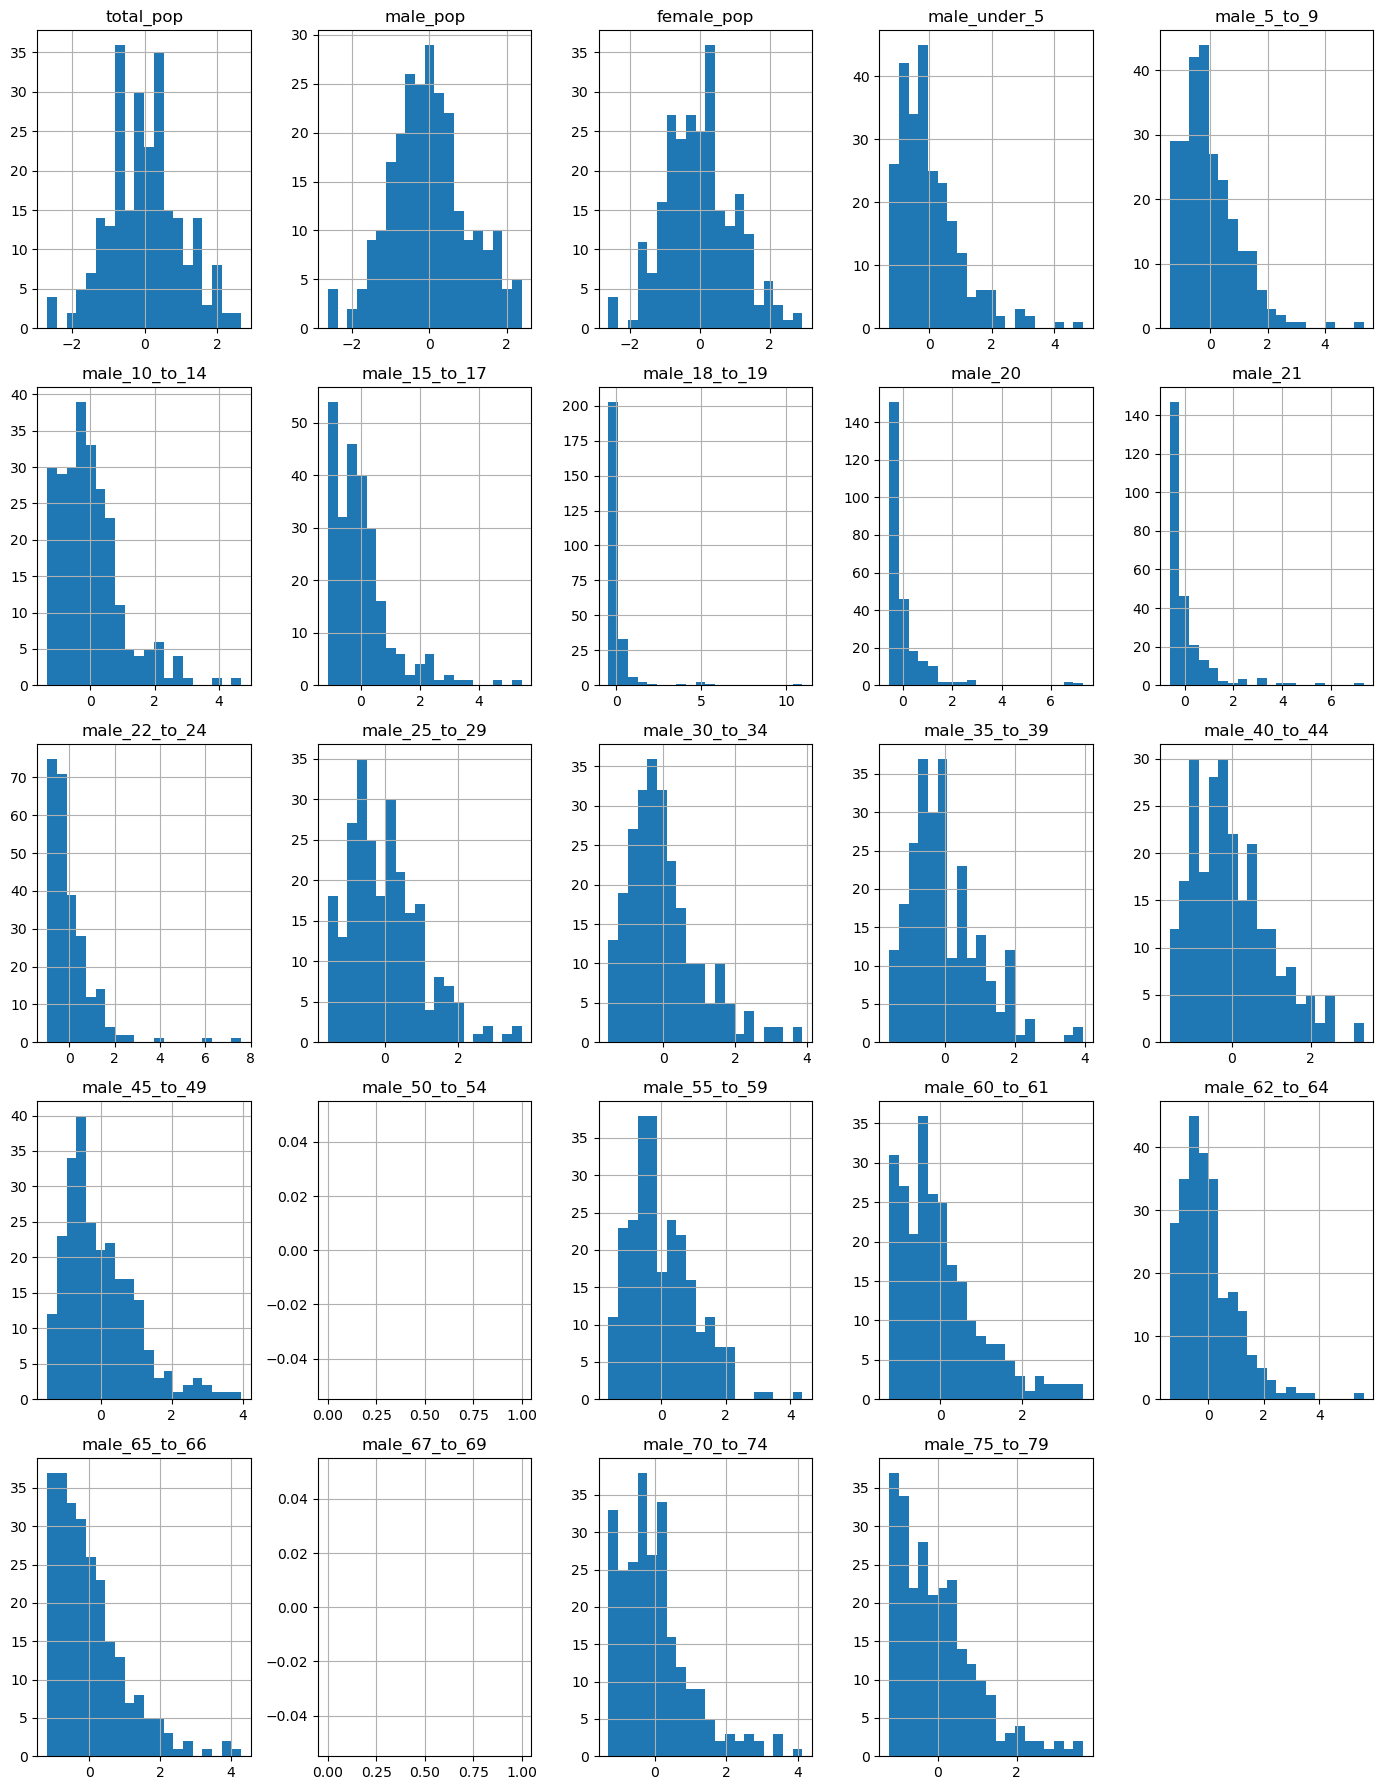

In [21]:
# 2) Missingness and summary statistics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 20)

# Percent missing per column
missing_pct = dp05_df_ri.isna().mean().sort_values(ascending=False)
print('Top missing columns:')
display(missing_pct.head(20))

# Describe numeric columns
num = dp05_df_ri.select_dtypes(include=['number'])
display(num.describe().T)

# Quick histograms for numerical columns (limited to reasonable number)
nplot = min(24, num.shape[1])
if nplot:
    ax = num.iloc[:, :nplot].hist(bins=20, figsize=(14, 3 * ((nplot+3)//4)))
    plt.tight_layout()

In [ ]:
# 3) Correlations with the binary target (point-biserial for continuous features)
from scipy.stats import pointbiserialr
import numpy as np

numeric_cols = num.columns.drop('high_rent_burden', errors='ignore')
corrs = []
for c in numeric_cols:
    col = dp05_df_ri[c]
    # dropna pairs
    mask = (~col.isna()) & (~dp05_df_ri['high_rent_burden'].isna())
    if mask.sum() < 5:
        continue
    try:
        r, p = pointbiserialr(dp05_df_ri.loc[mask, 'high_rent_burden'].astype(int), col.loc[mask])
    except Exception:
        r, p = np.nan, np.nan
    corrs.append((c, r, p))

corr_df = pd.DataFrame(corrs, columns=['feature','pointbiserial_r','pvalue']).dropna()
# Sort by absolute point-biserial correlation. Use key if available, else fall back to reindexing for older pandas versions.
try:
    corr_df = corr_df.sort_values(by='pointbiserial_r', key=lambda s: s.abs(), ascending=False)
except TypeError:
    # pandas < 1.1 may not support the 'key' argument on DataFrame.sort_values
,
,
,
20
,

TypeError: DataFrame.sort_values() missing 1 required positional argument: 'by'